<a href="https://colab.research.google.com/github/PratikshitSingh/A-ESRGANs/blob/main/444_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install basicsr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 22.6 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214841 sha256=d4960981a3c4bd7895f4d3c196d7fb3020c0d013c981b081e2097a692799b650
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built basicsr


In [ ]:
import os, random
import numpy as np
import torch
from basicsr.data.degradations import random_add_gaussian_noise_pt, random_add_poisson_noise_pt
from basicsr.data.transforms import paired_random_crop
from basicsr.models.srgan_model import SRGANModel
from basicsr.utils import DiffJPEG, USMSharp
from basicsr.utils.img_process_util import filter2D
from basicsr.utils.registry import MODEL_REGISTRY
from torchvision.transforms import GaussianBlur
from PIL import ImageFile, Image
from torch.utils import data
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import os
datadir = "/content/444_AESRGAN"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/444_AESRGAN" $datadir
os.chdir(datadir)
!pwd

/content/drive/.shortcut-targets-by-id/1oWPJkOBqv84-43qM398W9FXvkgjTWchj/444_AESRGAN


In [ ]:
data_path = "imgs"

In [ ]:
def get_all_file(target_dir,subfix=None): # just for this project
  g = os.walk(target_dir)
  data = []
  for path,dir_list,file_list in sorted(g):
    data += sorted(file_list)
  data = [os.path.join(target_dir,i) for i in data]
  if subfix != None:
    data = [i for i in data if i.endswith(subfix)]
  return data

In [ ]:
get_all_file("imgs/val", "png")

In [ ]:
class LoadData(data.Dataset):

  def __init__(self,split="train",preload=True, data_dir=data_path, num_data=None, image=None):
    assert(split in ["train","val","test"])
    # if split == "train":
    #   self.img_dir = os.path.join(img_dir,type_2)
    #   self.data_dir = os.path.join(data_dir,data_type)
    # else:
    #   self.img_dir = os.path.join(img_dir,split,type_2)
    #   self.data_dir = os.path.join(data_dir,split,data_type)
    # print(self.img_dir)
    # print(self.data_dir)

    # self.split = split
    # self.data = get_all_file(self.img_dir,subfix="png", img= type_2 == "")
    # self.mask_data = get_all_file(self.data_dir,subfix="png", img=False)
    self.img_dir = os.path.join(data_dir, split)
    self.data = get_all_file(self.img_dir, subfix="png")

    #insert dataloading here
    # self.img = image #temp testing var

    self.preload = preload
    self.usm_sharpener = USMSharp()
    self.jpeger = DiffJPEG(differentiable=False)
    self.blurrer = GaussianBlur(25)

    if preload:
      self.images = list(map(Image.open, self.data[:num_data]))
      
  def __len__(self):
    return len(self.images)
  
  def transform(self, img):
    # print(img.size())
    ori_h, ori_w = img.size()[1:]
    img = img.unsqueeze(0).float()
    img_usm = self.usm_sharpener(img)
    degen = self.blurrer(img_usm.clone())
    gauss_noise_prob = 0.5
    resize_range1 = 0.5
    resize_range2 = 0.25
    sigma_range = (1, 30)
    pscale = (0.05, 3)

    updown_type = random.choices(['up', 'down', 'keep'])[0]
    if updown_type == 'up':
        scale = np.random.uniform(1, 1 + resize_range1)
    elif updown_type == 'down':
        scale = np.random.uniform(1 - resize_range1, 1)
    else:
        scale = 1

    mode = random.choice(['area', 'bilinear', 'bicubic'])
    out = F.interpolate(degen, scale_factor=scale, mode=mode)

    gray_noise_prob = 0.33
    if np.random.uniform() < gauss_noise_prob:
        out = random_add_gaussian_noise_pt(
            out,
            sigma_range=sigma_range, 
            clip=True, 
            rounds=False, 
            gray_prob=gray_noise_prob)
    else:
        out = random_add_poisson_noise_pt(
            out,
            scale_range=pscale,
            gray_prob=gray_noise_prob,
            clip=True,
            rounds=False)
    # JPEG compression
    jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
    out = torch.clamp(out, 0, 1)
    out = self.jpeger(out, quality=jpeg_p)

    blur2_prob = 0.333
    if np.random.uniform() < blur2_prob:
        out = self.blurrer(out)
    # random resize
    updown_type = random.choices(['up', 'down', 'keep'])[0]
    if updown_type == 'up':
        scale = np.random.uniform(1, 1 + resize_range2)
    elif updown_type == 'down':
        scale = np.random.uniform(1 - resize_range2, 1)
    else:
        scale = 1
    mode = random.choice(['area', 'bilinear', 'bicubic'])
    scale_opt = 4
    out = F.interpolate(
        out, size=(int(ori_h / scale_opt * scale), int(ori_w / scale_opt * scale)), mode=mode)
    # noise
    if np.random.uniform() < gauss_noise_prob:
        out = random_add_gaussian_noise_pt(
            out, 
            sigma_range=sigma_range, 
            clip=True, 
            rounds=False, 
            gray_prob=gray_noise_prob)
    else:
        out = random_add_poisson_noise_pt(
            out,
            scale_range=pscale,
            gray_prob=gray_noise_prob,
            clip=True,
            rounds=False)

    mode = random.choice(['area', 'bilinear', 'bicubic'])
    out = F.interpolate(out, size=(ori_h // scale_opt, ori_w // scale_opt), mode=mode)

    jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
    out = torch.clamp(out, 0, 1)
    out = self.jpeger(out, quality=jpeg_p)
    return img_usm, out

  def __getitem__(self,idx):
    if self.preload:
      img = self.images[idx]
    else:
      img = cv2.imread(self.data[idx])
    img = np.transpose(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (2, 0, 1))
    img = torch.from_numpy(img) / 255.
    # print(img.max(), img.min())

    seed = np.random.randint(1000000000)

    gt, out = self.transform(img)

    if len(np.array(img).shape) == 3:
      ret_image = torch.permute(torch.tensor(np.array(img)), (2, 0, 1))
    else:
      ret_image = torch.tensor(np.array(img))
    return gt, out

In [ ]:
dataaset = LoadData(image=data_path, preload=False)

In [ ]:
gt, out = dataaset[10]

torch.Size([3, 1356, 2040])


torch.Size([1, 3, 339, 510])


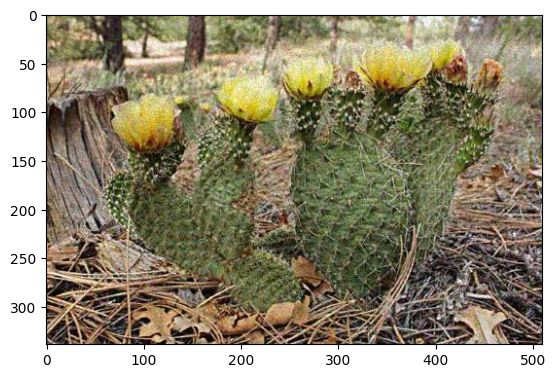

In [ ]:
print(out.size())
out = out.squeeze().permute(1, 2, 0).detach().numpy()
gt = gt.squeeze().permute(1, 2, 0).detach().numpy()

plt.imshow(out)


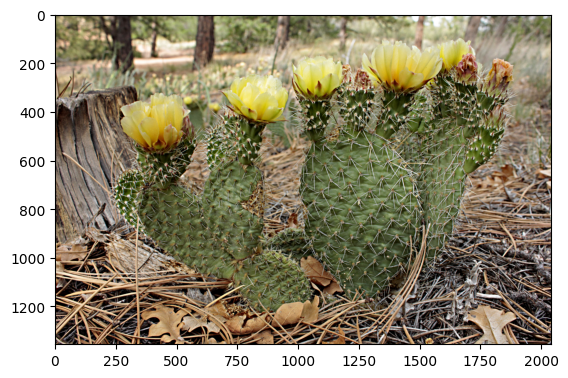

In [ ]:
plt.imshow(gt)


In [ ]:
print(out.shape)


cv2.imwrite("out_deg.png", cv2.cvtColor(out * 255, cv2.COLOR_RGB2BGR))
cv2.imwrite("gt_deg.png", cv2.cvtColor(gt * 255, cv2.COLOR_RGB2BGR))

(320, 480, 3)


True